## An end-to-end analysis of California housing prices
I analyze the California housing prices dataset from the StatLib repository. This dataset is based on data from the 1990 California census. The context is that this model will be part of a larger pipeline that will determine whether it is worth investing in a given area or not. The model will be fed with all the data about a district and it should predict the median housing price in that district. The model's output will be fed to another model, which will be used in the final investment decision.

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets", filter="data")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [3]:
# all numerical data (except ocean_proximity)
# total_bedrooms has some null values
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


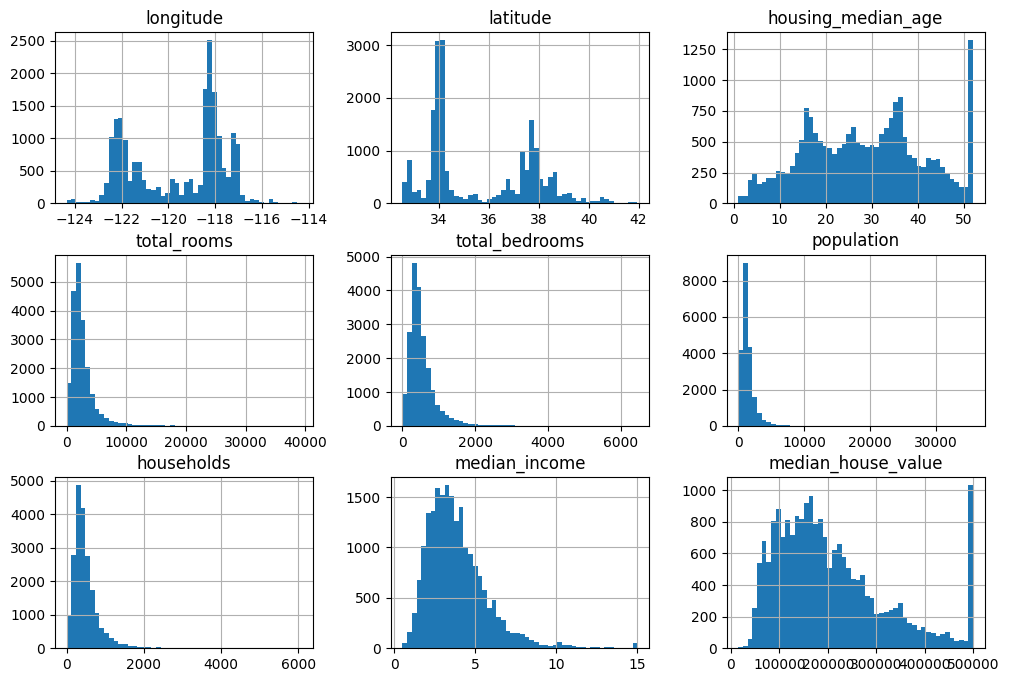

In [4]:
import matplotlib.pyplot as plt

# median age, income & value capped (remove capped value observations?)
housing.hist(bins=50, figsize=(12,8))
plt.show()


### Creating a test set.
One could use many strategies for creating a test set. Some include:
- Taking the first 20% of the data as the test set.
- Randomly selecting 20% of the data as the test set.

However, these naive strategies suffer from some serious flaws. Taking the first 20% of the data obviously won't work for data sorted in any kind of way as we'll be sampling a biased set of the whole dataset. To combat biased samples, you could pick the test set randomly but this introduces another problem: you'll be sampling a different test set on every run of your code. Even setting a random seed won't help as the dataset might change over time and eventually you'll be traingin on the whole dataset.

Intuition says, that out of all the features in the dataset, median income has a significant effect on housing prices. Thus, we might choose to pick the test/training set in a way that the distribution of the median income is similar in both sets (ie. stratified sampling). This way, we can ensure that the test set is representative of the whole dataset.

Stratifying seems like a good idea here. First we'll need to create an income category against which we can stratify the data.

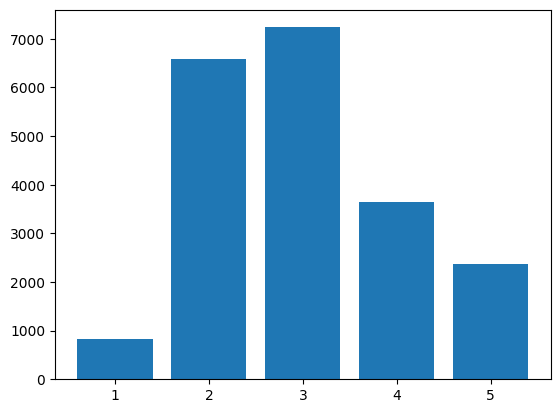

In [29]:
# Let's create an income category
import numpy as np

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf],
                               labels=[1,2,3,4,5])
category_counts = housing["income_cat"].value_counts()
plt.bar(category_counts.index, height=category_counts.values)
plt.show()

In [30]:
from sklearn.model_selection import train_test_split

strat_train, strat_test = train_test_split(
    housing, test_size=0.20, stratify=housing["income_cat"], random_state=3
)

# Distribution looks to be very similar
np.array([strat_test["income_cat"].value_counts() / len(strat_test), 
         housing["income_cat"].value_counts() / len(housing)])

array([[0.35053295, 0.31879845, 0.17635659, 0.11434109, 0.03997093],
       [0.3505814 , 0.3188469 , 0.17630814, 0.11443798, 0.03982558]])

In [60]:
# Drop the income_cat feature
strat_train.drop("income_cat", axis=1, inplace=True)
strat_test.drop("income_cat", axis=1, inplace=True)

## More data exploration

<Axes: xlabel='longitude', ylabel='latitude'>

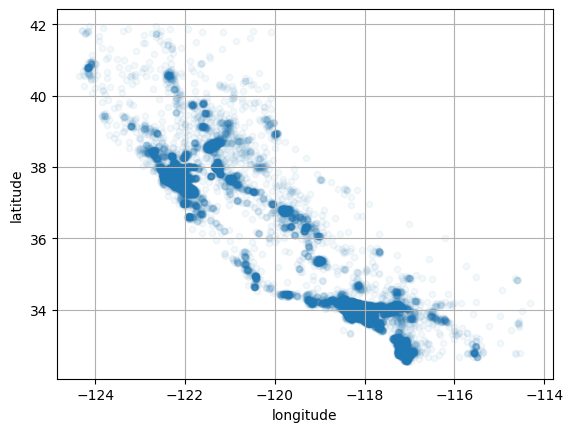

In [61]:
housing = strat_train.copy()

# housing density
housing.plot(kind="scatter", x="longitude", y="latitude", grid=1, alpha=0.05)

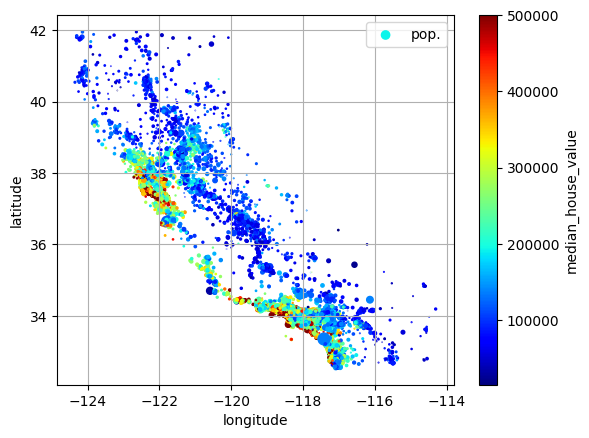

In [62]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 500, label="pop.",
             c="median_house_value", cmap="jet", colorbar=True, 
             legend=True, sharex=False)
plt.show()

In [63]:
# Create some more useful features
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [64]:
# looks like the new ratios correlate better with median value
corr_matrix = housing.drop("ocean_proximity", axis=1).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687778
rooms_per_house       0.147878
total_rooms           0.132725
housing_median_age    0.104174
households            0.066143
total_bedrooms        0.048847
people_per_house     -0.019811
population           -0.025532
longitude            -0.047638
latitude             -0.141908
bedrooms_ratio       -0.255438
Name: median_house_value, dtype: float64

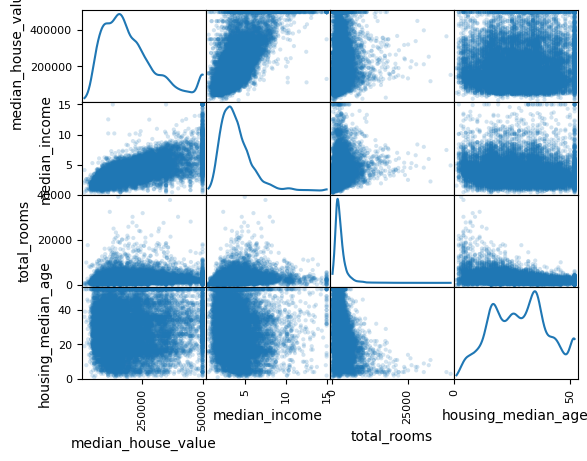

In [35]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], alpha=0.2, diagonal="kde")
plt.show()

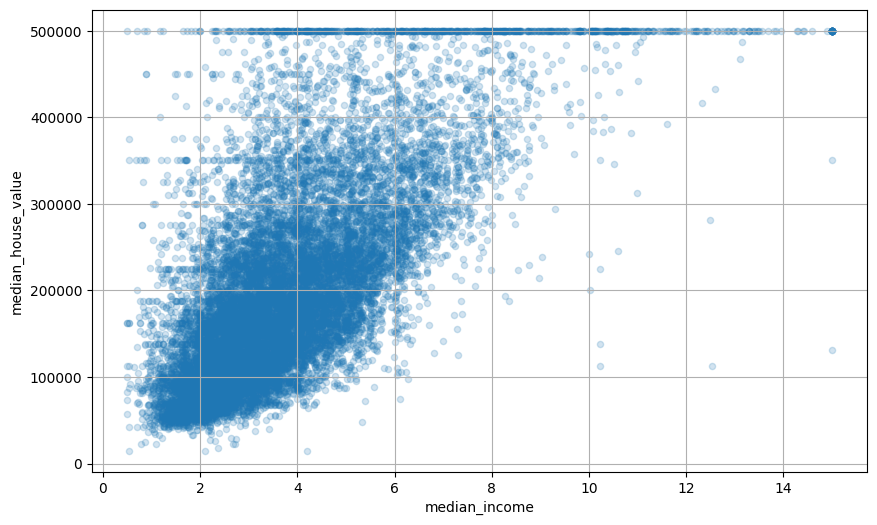

In [36]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", grid=True, 
             alpha=0.2, figsize=(10,6))
plt.show()

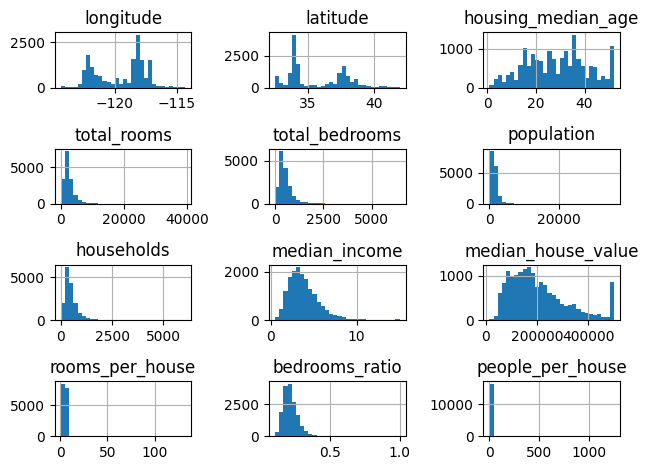

In [37]:
# 
housing.hist(bins=30)
plt.tight_layout()
plt.show()

## Cleaning the data

*Pipeline:*
1. impute missing numerical values with feature median / categorical w/ most frequent
2. one-hot encode categorical features
3. add ratios: bedrooms-to-all_rooms, rooms-to-houses, people-per-house
4. add cluster similarity based on longitude & latitude (ie. is in big city)
5. replace long-tailed features with log(feature)
6. standardize all numerical features

In [65]:
# Let's start by making new copies
housing = strat_train.drop("median_house_value", axis=1)
housing_labels = strat_train["median_house_value"].copy()

In [66]:
# The pipeline for the columns that are transformed into ratios:

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, input_names):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

In [67]:
# The pipeline for the columns that have a log transormation

def log_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(np.log, feature_names_out="one-to-one"),
        StandardScaler()
    )

In [68]:
# The pipeline for clustering transformations (latitude & longitude for major cities)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=4, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X, y=None):
        cluster_centers = self.kmeans.cluster_centers_
        return rbf_kernel(X, cluster_centers, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"cluster_{i}" for i in range(self.n_clusters)]

def cluster_pipeline():
    return ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)

In [69]:
# The pipeline for categorical features

from sklearn.preprocessing import OneHotEncoder

def cat_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore")
    )

In [70]:
# The pipeline for all other numerical features

def default_num_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        StandardScaler()
    )

In [71]:
# Now we bring all the sub-pipelines together into a preprocessing pipeline

from sklearn.compose import ColumnTransformer, make_column_selector

preprocessing = ColumnTransformer([
        ("bedrooms_per_rooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("population_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline(), ["total_bedrooms", "total_rooms", "population", 
                                "households", "median_income"]),
        ("geo", cluster_pipeline(), ["longitude", "latitude"]),
        ("cat", cat_pipeline(), make_column_selector(dtype_include=object))
    ],
    remainder=default_num_pipeline()
    )

In [72]:
# Let's run our data through the preprocessing pipeline

housing_prepared = pd.DataFrame(
    data=preprocessing.fit_transform(housing),
    columns=preprocessing.get_feature_names_out()
)
housing_prepared.head()

,bedrooms_per_rooms__ratio,rooms_per_house__ratio,population_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__cluster_0,geo__cluster_1,geo__cluster_2,geo__cluster_3,geo__cluster_4,geo__cluster_5,geo__cluster_6,geo__cluster_7,geo__cluster_8,geo__cluster_9,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
0,-0.725945,0.954760,0.017656,-0.291033,0.004949,-0.339458,-0.528010,0.883986,1.048259e-09,0.725776,5.785603e-15,4.083255e-24,3.676056e-03,2.218217e-04,0.290158,0.375013,2.760046e-18,7.553355e-06,0.0,1.0,0.0,0.0,0.0,-2.194596
1,0.583872,-0.484769,-0.060260,0.426459,0.149801,0.199934,0.415684,-1.590416,4.101540e-10,0.394207,2.359116e-15,1.500950e-24,7.101784e-03,2.319010e-04,0.285890,0.710630,1.972122e-18,1.835623e-06,0.0,1.0,0.0,0.0,0.0,0.423158
2,-0.544460,0.149572,-0.007252,0.589180,0.768517,0.704683,0.639992,0.440062,7.165940e-13,0.353111,5.663178e-19,3.293806e-29,3.278143e-02,9.781921e-07,0.022929,0.090722,6.264343e-23,6.102868e-08,1.0,0.0,0.0,0.0,0.0,-1.559989
3,-0.830536,0.469331,0.000501,1.064017,1.377244,1.193164,1.095314,1.032508,6.782931e-03,0.001628,1.963629e-05,5.307872e-11,1.199569e-10,9.092993e-01,0.108600,0.001551,5.143777e-07,3.002541e-02,0.0,1.0,0.0,0.0,0.0,-1.480663
4,0.782366,-0.538904,0.198407,0.125983,-0.208921,0.900690,0.090119,-0.651464,2.619781e-09,0.967127,1.498724e-14,1.313106e-23,1.094272e-03,1.764529e-04,0.218363,0.132414,4.130979e-18,2.857907e-05,0.0,0.0,0.0,1.0,0.0,1.057765


## Selecting a model and training it

In [79]:
# Let's start from a very basic linear regression model
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

housing_predictions = lin_reg.predict(housing)

In [87]:
# Let's see how we did according to the root mean squared error (RMSE)
from sklearn.metrics import root_mean_squared_error

lin_rmse = root_mean_squared_error(housing_predictions, housing_labels)
print(f"The RMSE is: ${round(float(lin_rmse), 2)}")


The RMSE is: $69694.56


In [89]:
# The linreg performs pretty poorly so let's try a more powerful model
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

tree_reg_predictions = tree_reg.predict(housing)

In [90]:
# Here's how the decision tree regression performs
tree_rmse = root_mean_squared_error(tree_reg_predictions, housing_labels)
print(f"The RMSE is: ${round(float(tree_rmse), 2)}")

The RMSE is: $0.0


An RMSE of 0? The model is clearly overfitting the trainng data. A better way to evaluate the model is to use cross-validation. This means that we split the training data into k-folds and train the model k times, each time using a different fold as the validation set. This way, we can get a better estimate of the model's performance on unseen data.

In [92]:
# Here we see that the DTR doesn't perform that well after all
from sklearn.model_selection import cross_val_score

num_of_folds = 10
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, 
                             scoring="neg_root_mean_squared_error",
                             cv=num_of_folds)
pd.Series(tree_rmses).describe()

count       10.000000
mean     66673.190571
std       1939.387202
min      64836.708960
25%      65018.446244
50%      66385.624328
75%      67167.888067
max      70467.512902
dtype: float64

In [93]:
# Let's see what the linear reg looks like when we use cross-validation
linreg_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error",
                                cv=num_of_folds)

pd.Series(linreg_rmses).describe()

count       10.000000
mean     71359.511493
std       3983.997355
min      67559.588998
25%      68978.934316
50%      70083.901361
75%      70938.625375
max      79002.440174
dtype: float64

In [94]:
# Let's try one more model: the random forest regressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error",
                                cv=num_of_folds)

pd.Series(forest_rmses).describe()

count       10.000000
mean     47221.146217
std       1293.331542
min      44638.819685
25%      46828.356990
50%      47032.595421
75%      47844.903913
max      49203.222454
dtype: float64

### Fine tuning the model
We could manually fine-tune the hyperparameters of the model but this is a tedious process. Instead, we could use GridSearchCV to search for the best hyperparameters. This will search through all the possible combinations of hyperparameters and return the best one.

In [99]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {"preprocessing__geo__n_clusters": [5, 8, 10],
     "random_forest__max_features": [4, 6, 8]},
    {"preprocessing__geo__n_clusters": [10, 15],
     "random_forest__max_features": [6, 8, 10]}
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring="neg_root_mean_squared_error")
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms_per_rooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_na...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x1439c54c0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [100]:
# The best hyperparameter combination of the 15 variations is:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [108]:
# We can see all the variations with:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,5.368543,0.093468,0.142604,0.000339,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-43633.683385,-44110.403814,-44810.585062,-44184.890754,483.346403,1
13,7.045150,0.217936,0.142848,0.000198,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-43914.295925,-44304.295135,-45120.324241,-44446.305100,502.494575,2
14,8.548179,0.042184,0.140614,0.003771,15,10,"{'preprocessing__geo__n_clusters': 15, 'random...",-44842.985864,-45121.126315,-45544.649545,-45169.587241,288.495322,3
7,5.247104,0.048676,0.142099,0.000602,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44977.959942,-45587.783772,-46031.058162,-45532.267292,431.714045,4
9,5.277746,0.084962,0.174705,0.045754,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44977.959942,-45587.783772,-46031.058162,-45532.267292,431.714045,4


In [107]:
# Manually selecting all the variations is kind of boring so sklearn also has
# a randomized search CV that picks the hyperparameters stochastically
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distibs = {
    "preprocessing__geo__n_clusters": randint(low=3, high=50),
    "random_forest__max_features": randint(low=2, high=20)
}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distibs,
    n_iter=10, cv=3, scoring="neg_root_mean_squared_error",
    random_state=42
)

rnd_search.fit(housing, housing_labels)

{'preprocessing__geo__n_clusters': 45, 'random_forest__max_features': 9}

In [115]:
final_model = rnd_search.best_estimator_
feature_importance = final_model["random_forest"]

RandomForestRegressor(max_features=9, random_state=42)